In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # <<< ¡Asegúrate de que esta línea no dé error! Intenta reiniciar el kernel si lo hace.

In [9]:
# --- PASO 0: Definir la ruta base RELATIVA al notebook ---
# El notebook está en EDAS/, los datos están en data/
# La ruta desde EDAS/ a data/ es '../data/'
BASE_DATA_PATH = '../data'

print(f"Buscando datos en: {os.path.abspath(BASE_DATA_PATH)}") # Imprime la ruta absoluta para verificar

Buscando datos en: c:\Users\Omar\Desktop\trabajo\repositorios\world-population-eda\data


In [10]:
# --- PASO 1: Cargar los Datos ---
# Construir rutas completas a los archivos usando os.path.join
data_file = os.path.join(BASE_DATA_PATH, 'API_SM.POP.NETM_DS2_en_csv_v2_13382.csv')
# meta_country_file = os.path.join(BASE_DATA_PATH, 'Metadata_Country_API_SM.POP.NETM_DS2_en_csv_v2_13382.csv') # <<-- COMENTADO
# meta_indicator_file = os.path.join(BASE_DATA_PATH, 'Metadata_Indicator_API_SM.POP.NETM_DS2_en_csv_v2_13382.csv') # <<-- COMENTADO

try:
    # Verificar si el archivo principal existe antes de intentar leerlo
    if not os.path.exists(data_file):
        raise FileNotFoundError(f"El archivo de datos NO se encontró en la ruta esperada: {data_file}\nDirectorio actual del notebook: {os.getcwd()}")

    df_data = pd.read_csv(data_file, skiprows=4)
    print(f"Archivo de datos '{data_file}' cargado exitosamente.")

    # --- Carga Opcional de Metadata (Comentada) ---
    # Descomenta si tienes los archivos y quieres usarlos
    # if os.path.exists(meta_country_file) and os.path.exists(meta_indicator_file):
    #     df_meta_country = pd.read_csv(meta_country_file)
    #     df_meta_indicator = pd.read_csv(meta_indicator_file)
    #     print("Archivos de metadatos cargados exitosamente.")
    # else:
    #     print("Advertencia: No se encontraron uno o ambos archivos de metadatos en la ruta esperada.")
    # --- Fin Carga Opcional ---

except FileNotFoundError as e:
    print(f"Error Crítico: {e}")
    print("Verifica que la carpeta 'data' exista un nivel POR ENCIMA de la carpeta 'EDAS' donde está tu notebook.")
    # exit() # En un notebook, 'exit()' puede detener el kernel, quizás solo quieras detener la ejecución de esta celda.
    raise # Vuelve a lanzar el error para detener la ejecución de la celda si el archivo no se encuentra.

Archivo de datos '../data\API_SM.POP.NETM_DS2_en_csv_v2_13382.csv' cargado exitosamente.


In [ ]:
# --- PASO 2: Entender el Indicador (Comentado si no se cargó metadata) ---
# print("\n--- Información del Indicador ---")
# try:
#     print(df_meta_indicator[df_meta_indicator['INDICATOR_CODE'] == 'SM.POP.NETM'])
# except NameError:
#      print("No se cargaron los metadatos del indicador (archivo no encontrado o sección comentada).")
# except Exception as e:
#      print(f"Error al intentar mostrar metadatos del indicador: {e}")

In [11]:
# --- PASO 3: Extraer y Preparar los Datos de Perú ---

peru_data_wide_full = df_data[df_data['Country Code'] == 'PER'].copy()

if peru_data_wide_full.empty:
    print("\nError: No se encontraron datos para Perú (Código PER) en el archivo cargado.")
    # Considera detener la ejecución aquí si no hay datos
    raise ValueError("No hay datos para Perú.") # Detiene la ejecución de la celda

# Seleccionar solo las columnas de años NUMÉRICOS
cols_years = [col for col in peru_data_wide_full.columns if col.isdigit()]
peru_data_wide_years_only = peru_data_wide_full[cols_years].copy()

# Transformar de formato ancho (wide) a largo (long)
peru_data_long = peru_data_wide_years_only.melt(var_name='Year', value_name='Net Migration')

# Convertir las columnas a tipos de datos adecuados
peru_data_long['Year'] = pd.to_numeric(peru_data_long['Year'], errors='raise')
peru_data_long['Net Migration'] = pd.to_numeric(peru_data_long['Net Migration'], errors='coerce')

# Ordenar por año
peru_data_long = peru_data_long.sort_values('Year').reset_index(drop=True)

print("\n--- Primeras filas de datos procesados para Perú ---")
print(peru_data_long.head())
print("\n--- Últimas filas de datos procesados para Perú ---")
print(peru_data_long.tail())


--- Primeras filas de datos procesados para Perú ---
   Year  Net Migration
0  1960        -7236.0
1  1961        -7063.0
2  1962        -9051.0
3  1963       -10040.0
4  1964       -12129.0

--- Últimas filas de datos procesados para Perú ---
    Year  Net Migration
59  2019        74270.0
60  2020        55375.0
61  2021        41868.0
62  2022        33982.0
63  2023        24783.0


In [12]:
# --- PASO 4: Limpieza - Manejo de Valores Faltantes ---
missing_values = peru_data_long['Net Migration'].isnull().sum()
print(f"\nNúmero de valores faltantes en 'Net Migration' para Perú: {missing_values}")
if missing_values > 0:
    print("Años con valores faltantes:")
    print(peru_data_long[peru_data_long['Net Migration'].isnull()]['Year'].tolist())
# Opcional: Imputación
# peru_data_long['Net Migration'] = peru_data_long['Net Migration'].interpolate(method='linear')


Número de valores faltantes en 'Net Migration' para Perú: 0


In [13]:
# --- PASO 5: Análisis Descriptivo Básico ---
print("\n--- Estadísticas Descriptivas de Migración Neta para Perú ---")
if peru_data_long['Net Migration'].notna().any():
    print(peru_data_long['Net Migration'].describe())
    valid_migration_data = peru_data_long.dropna(subset=['Net Migration'])
    if not valid_migration_data.empty:
        max_emigration_year = valid_migration_data.loc[valid_migration_data['Net Migration'].idxmin()]
        max_immigration_year = valid_migration_data.loc[valid_migration_data['Net Migration'].idxmax()]
        print(f"\nMáxima emigración neta registrada: {max_emigration_year['Net Migration']:,.0f} en el año {int(max_emigration_year['Year'])}")
        print(f"Máxima inmigración neta registrada: {max_immigration_year['Net Migration']:,.0f} en el año {int(max_immigration_year['Year'])}")
    else:
        print("\nNo hay datos válidos de migración para calcular máximos y mínimos.")
else:
    print("\nNo hay datos numéricos de migración para calcular estadísticas.")


--- Estadísticas Descriptivas de Migración Neta para Perú ---
count        64.000000
mean     -41932.015625
std       91955.880875
min     -236745.000000
25%      -52662.500000
50%      -26654.000000
75%      -10852.250000
max      339067.000000
Name: Net Migration, dtype: float64

Máxima emigración neta registrada: -236,745 en el año 2007
Máxima inmigración neta registrada: 339,067 en el año 2018


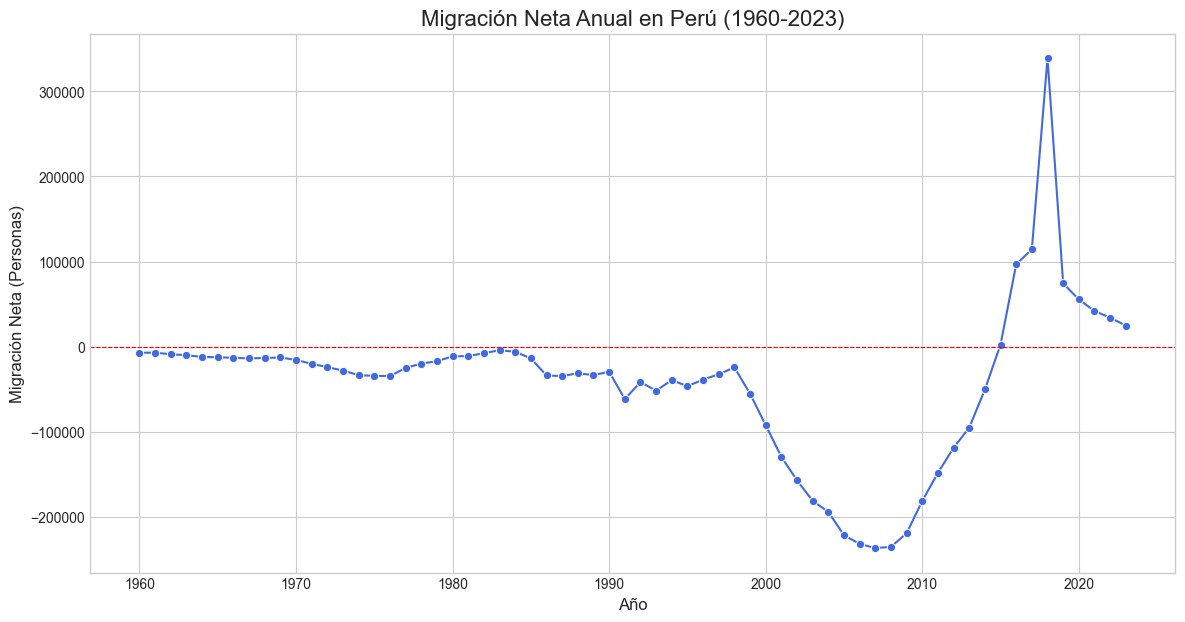

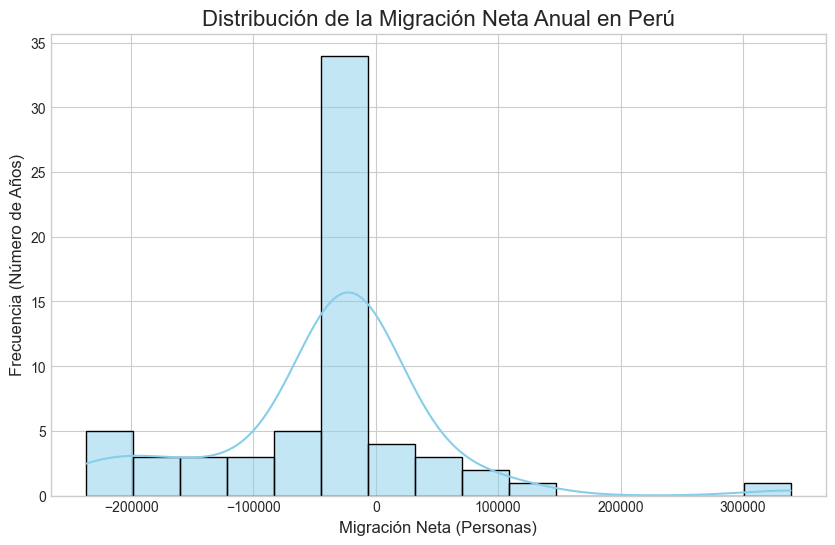

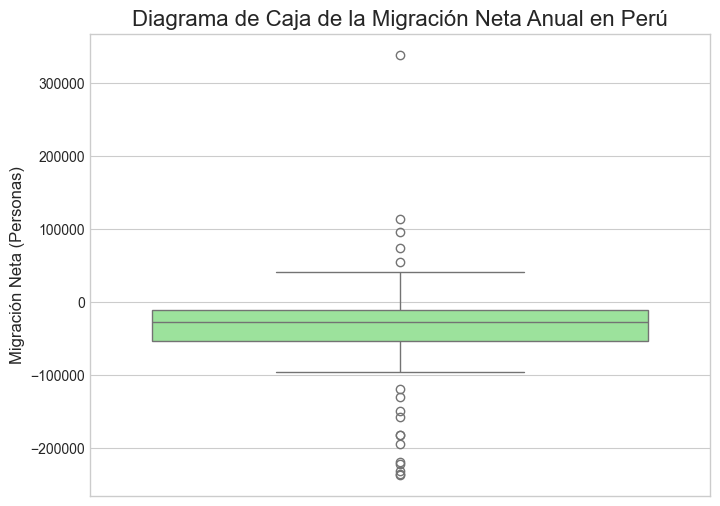

In [14]:
# --- PASO 6: Visualización ---
if peru_data_long['Net Migration'].notna().any():
    plt.style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=peru_data_long.dropna(subset=['Net Migration']), x='Year', y='Net Migration', marker='o', color='royalblue')
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
    plt.title('Migración Neta Anual en Perú (1960-2023)', fontsize=16)
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('Migración Neta (Personas)', fontsize=12)
    plt.grid(True)
    plt.show() # <<< Muestra el gráfico en la salida del notebook

    plt.figure(figsize=(10, 6))
    sns.histplot(data=peru_data_long.dropna(subset=['Net Migration']), x='Net Migration', kde=True, bins=15, color='skyblue')
    plt.title('Distribución de la Migración Neta Anual en Perú', fontsize=16)
    plt.xlabel('Migración Neta (Personas)', fontsize=12)
    plt.ylabel('Frecuencia (Número de Años)', fontsize=12)
    plt.grid(True, axis='y')
    plt.show() # <<< Muestra el gráfico

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=peru_data_long.dropna(subset=['Net Migration']), y='Net Migration', color='lightgreen')
    plt.title('Diagrama de Caja de la Migración Neta Anual en Perú', fontsize=16)
    plt.ylabel('Migración Neta (Personas)', fontsize=12)
    plt.grid(True, axis='y')
    plt.show() # <<< Muestra el gráfico

In [15]:
# --- PASO 7: Interpretación Inicial (Ejemplos) ---
print("\n--- Interpretación Inicial (Basada en Gráficos y Estadísticas) ---")
# (El código de interpretación es el mismo que antes, asegúrate de que las variables calculadas existan)
if peru_data_long['Net Migration'].notna().any():
    print("1. Tendencia General: Observa el gráfico de línea. ¿Perú ha sido históricamente un país de emigración (valores < 0) o inmigración (valores > 0)? ¿Ha habido cambios significativos en esta tendencia?")
    print("2. Picos y Valles: ¿En qué años se observan los picos de emigración (valles más profundos) o inmigración (picos más altos)? Estos podrían correlacionarse con eventos históricos, económicos o políticos.")
    print("3. Distribución: El histograma y el boxplot muestran cómo se agrupan los valores anuales. ¿Son la mayoría de los años de emigración moderada/alta? ¿Hay años con valores muy extremos (outliers)?")
    try:
        mean_mig = peru_data_long['Net Migration'].mean()
        median_mig = peru_data_long['Net Migration'].median()
        min_mig = peru_data_long['Net Migration'].min()
        max_mig = peru_data_long['Net Migration'].max()
        print(f"   - La media ({mean_mig:,.0f}) y la mediana ({median_mig:,.0f}) dan una idea del valor 'típico' anual.")
        print(f"   - El rango va desde {min_mig:,.0f} hasta {max_mig:,.0f}.")
    except TypeError:
        print("   - No se pueden calcular estadísticas sumarias (media, mediana, rango) debido a datos faltantes o no numéricos.")
else:
    print("\nNo se pueden generar interpretaciones porque no hay datos de migración válidos.")

print("\n--- Análisis Completado ---")


--- Interpretación Inicial (Basada en Gráficos y Estadísticas) ---
1. Tendencia General: Observa el gráfico de línea. ¿Perú ha sido históricamente un país de emigración (valores < 0) o inmigración (valores > 0)? ¿Ha habido cambios significativos en esta tendencia?
2. Picos y Valles: ¿En qué años se observan los picos de emigración (valles más profundos) o inmigración (picos más altos)? Estos podrían correlacionarse con eventos históricos, económicos o políticos.
3. Distribución: El histograma y el boxplot muestran cómo se agrupan los valores anuales. ¿Son la mayoría de los años de emigración moderada/alta? ¿Hay años con valores muy extremos (outliers)?
   - La media (-41,932) y la mediana (-26,654) dan una idea del valor 'típico' anual.
   - El rango va desde -236,745 hasta 339,067.

--- Análisis Completado ---



--- Generando Mapa de Calor Comparativo ---
Mostrando heatmap desde el año 1990.


C:\Users\Omar\AppData\Local\Temp\ipykernel_4272\2953862028.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_matrix[col] = pd.to_numeric(heatmap_matrix[col], errors='coerce')


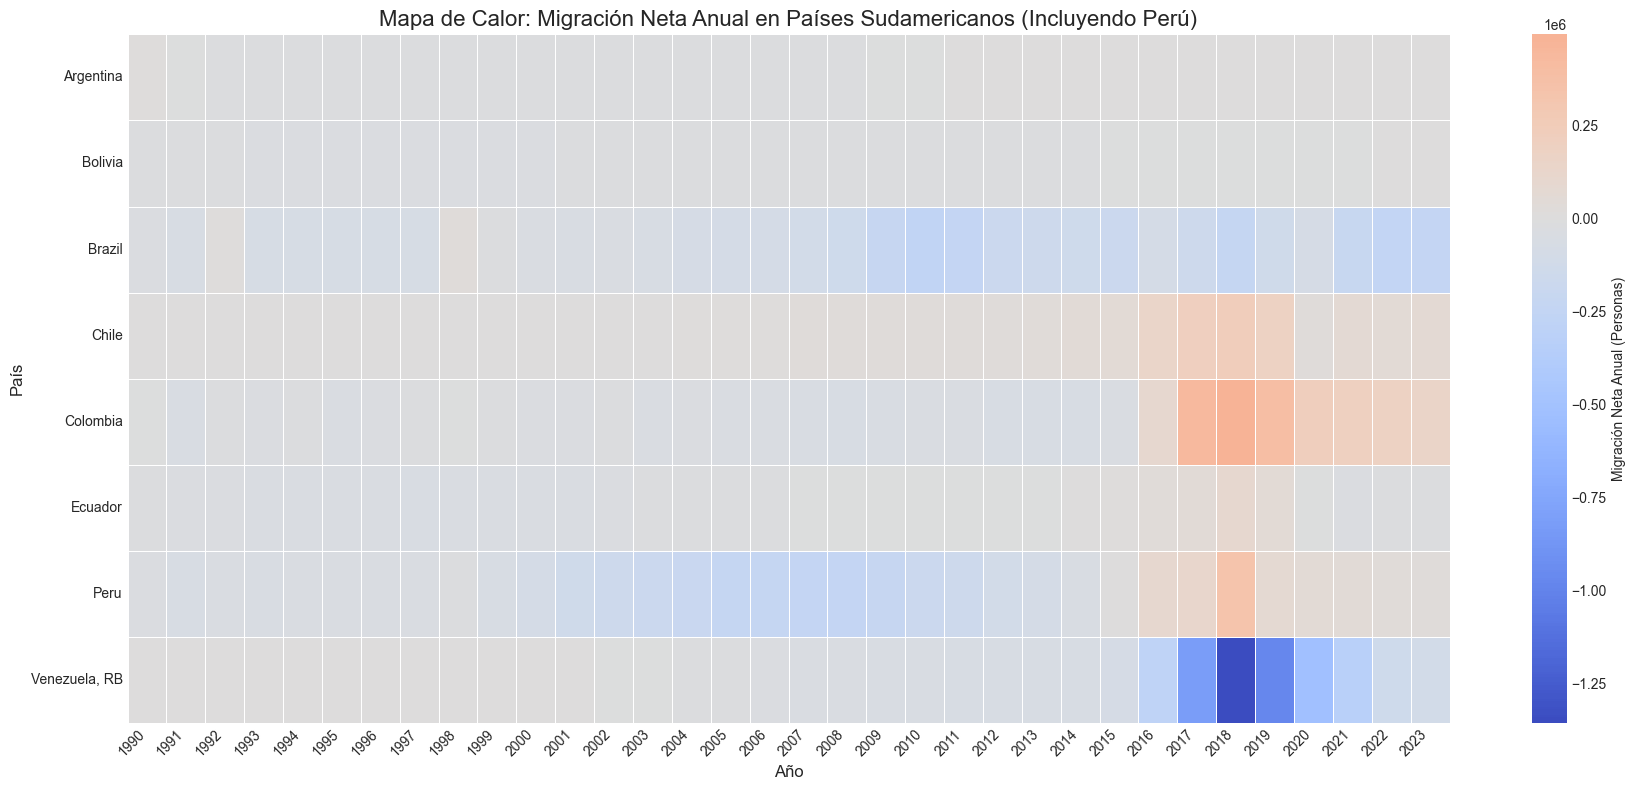


--- Interpretación del Mapa de Calor ---
Observa los colores para cada país a lo largo de los años:
- Colores Rojos/Cálidos: Indican inmigración neta (más gente llegando que saliendo).
- Colores Azules/Fríos: Indican emigración neta (más gente saliendo que llegando).
- Color cercano al centro (blanco/gris claro): Migración neta cercana a cero.
Compara la fila de Perú con las de otros países para ver tendencias similares o diferentes.
Busca cambios abruptos de color en un país, podrían indicar eventos significativos.


In [16]:
# --- PASO 8: Mapa de Calor Comparativo (Incluyendo Perú) ---
print("\n--- Generando Mapa de Calor Comparativo ---")

# 1. Seleccionar Países (Ejemplo: Perú y otros países sudamericanos)
# Puedes ajustar esta lista según tu interés
country_codes_to_compare = [
    'PER', # Perú
    'ARG', # Argentina
    'BOL', # Bolivia
    'BRA', # Brasil
    'CHL', # Chile
    'COL', # Colombia
    'ECU', # Ecuador
    'VEN', # Venezuela
    # 'PRY', 'URY', 'GUY', 'SUR' # Otros opcionales
]

# 2. Filtrar Datos del DataFrame Original
comparison_data = df_data[df_data['Country Code'].isin(country_codes_to_compare)].copy()

if comparison_data.empty:
    print("Error: No se encontraron datos para los países seleccionados para la comparación.")
    # Puedes decidir si detener o continuar sin el heatmap
    # raise ValueError("No hay datos para los países del heatmap.")
else:
    # 3. Preparar Matriz para Heatmap
    # Usar 'Country Name' como índice para etiquetas más claras
    comparison_data = comparison_data.set_index('Country Name')

    # Seleccionar solo las columnas de años (ya las identificamos antes en cols_years)
    # Asegurarnos de que cols_years contiene los nombres de columna correctos
    year_columns = [col for col in comparison_data.columns if col.isdigit()]
    heatmap_matrix = comparison_data[year_columns]

    # Convertir todas las columnas de años a numérico (importante!)
    # Los errores (ej. '..') se convertirán en NaN
    for col in year_columns:
        heatmap_matrix[col] = pd.to_numeric(heatmap_matrix[col], errors='coerce')

    # Opcional: Filtrar años si el rango es demasiado grande para visualizar bien
    # Ejemplo: Últimos 30 años
    start_year_heatmap = '1990' # Puedes ajustar esto
    if start_year_heatmap in heatmap_matrix.columns:
         heatmap_matrix = heatmap_matrix.loc[:, start_year_heatmap:] # Selecciona desde el año inicial hasta el final
         print(f"Mostrando heatmap desde el año {start_year_heatmap}.")
    else:
         print("Mostrando heatmap para todos los años disponibles.")


    # Eliminar filas (países) que solo tengan valores NaN después de la conversión/filtrado de años
    heatmap_matrix.dropna(axis=0, how='all', inplace=True)

    if heatmap_matrix.empty:
        print("Error: No quedaron datos válidos para generar el heatmap después de la limpieza.")
    else:
        # 4. Generar Heatmap
        plt.figure(figsize=(18, 8)) # Ajusta el tamaño según necesidad (más ancho por los años)

        # Usar un colormap divergente es bueno para ver positivos/negativos respecto a cero
        # cmap='coolwarm', cmap='RdBu_r', cmap='viridis' son opciones
        sns.heatmap(
            heatmap_matrix,
            cmap='coolwarm',       # Colormap: azul (negativo/emigración) a rojo (positivo/inmigración)
            center=0,             # Centrar la barra de color en 0
            annot=False,          # No mostrar los números en las celdas (demasiados)
            fmt=".0f",            # Formato si annot=True (ignorado si annot=False)
            linewidths=.5,        # Líneas finas entre celdas
            cbar_kws={'label': 'Migración Neta Anual (Personas)'} # Etiqueta de la barra de color
        )

        plt.title('Mapa de Calor: Migración Neta Anual en Países Sudamericanos (Incluyendo Perú)', fontsize=16)
        plt.xlabel('Año', fontsize=12)
        plt.ylabel('País', fontsize=12)
        plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje X (años) para mejor lectura
        plt.yticks(rotation=0) # Asegurar que los nombres de países estén horizontales
        plt.tight_layout() # Ajustar layout para evitar solapamientos
        plt.show()

        print("\n--- Interpretación del Mapa de Calor ---")
        print("Observa los colores para cada país a lo largo de los años:")
        print("- Colores Rojos/Cálidos: Indican inmigración neta (más gente llegando que saliendo).")
        print("- Colores Azules/Fríos: Indican emigración neta (más gente saliendo que llegando).")
        print("- Color cercano al centro (blanco/gris claro): Migración neta cercana a cero.")
        print("Compara la fila de Perú con las de otros países para ver tendencias similares o diferentes.")
        print("Busca cambios abruptos de color en un país, podrían indicar eventos significativos.")

# Fin del bloque del heatmap